In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

Загрузка датасета

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'datasets', 'Churn_Modelling.csv')
def load_data(data_path=DATA_PATH):
    return pd.read_csv(data_path)

In [3]:
data = load_data()
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Замена категориальных признаков на численные

In [4]:
data = pd.get_dummies(data, columns=['Geography'], prefix='From', prefix_sep='', dtype=np.int64)
data['Gender'] = data['Gender'].map({'Male' : 1, 'Female' : 0})

Генерация нового признака

In [5]:
data['TenurePerAge'] = data['Tenure'] / data['Age']

Удаление лишних признаков

In [6]:
drop_list = ['CustomerId', 'Surname', 'RowNumber', 'HasCrCard', 'EstimatedSalary', 'Tenure']
data.drop(drop_list, axis=1, inplace=True)

data = (data - data.min()) / (data.max() - data.min())

In [7]:
data.head()

,CreditScore,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited,FromFrance,FromGermany,FromSpain,TenurePerAge
0,0.538,0.0,0.324324,0.000000,0.000000,1.0,1.0,1.0,0.0,0.0,0.085714
1,0.516,0.0,0.310811,0.334031,0.000000,1.0,0.0,0.0,0.0,1.0,0.043902
2,0.304,0.0,0.324324,0.636357,0.666667,0.0,1.0,1.0,0.0,0.0,0.342857
3,0.698,0.0,0.283784,0.000000,0.333333,0.0,0.0,1.0,0.0,0.0,0.046154
4,1.000,0.0,0.337838,0.500246,0.000000,1.0,0.0,0.0,0.0,1.0,0.083721


Подготовка обучающих и тестовых данных

In [8]:
X = data.drop('Exited', axis=1)
y = data['Exited']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=50)

In [10]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
font = {'size': 15}
plt.rc('font', **font)

# Логистическая регрессия

Моя реализация логистической регрессии

In [12]:
class LogisticRegression_:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X_ = self.__add_intercept(X)
        
        self.theta = np.random.normal(size=X_.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X_, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X_.T, (h - y)) / y.shape[0]
            self.theta -= self.lr * gradient
                
    def predict(self, X, threshold=0.5):
        if self.fit_intercept:
            X_ = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X_, self.theta)) >= threshold

Обучение моделей

In [13]:
my_lr = LogisticRegression_()
my_lr.fit(x_train, y_train)

In [14]:
lr = LogisticRegression(random_state=50)
lr.fit(x_train, y_train)

LogisticRegression(random_state=50)

Сравнение результатов

Confusion matrix
[[1553   40]
 [ 332   75]]


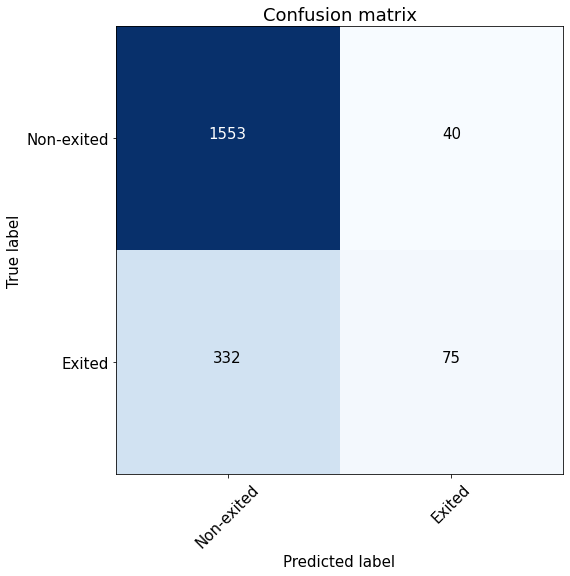

In [15]:
cnf_matrix = confusion_matrix(y_test, my_lr.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

Confusion matrix
[[1550   43]
 [ 329   78]]


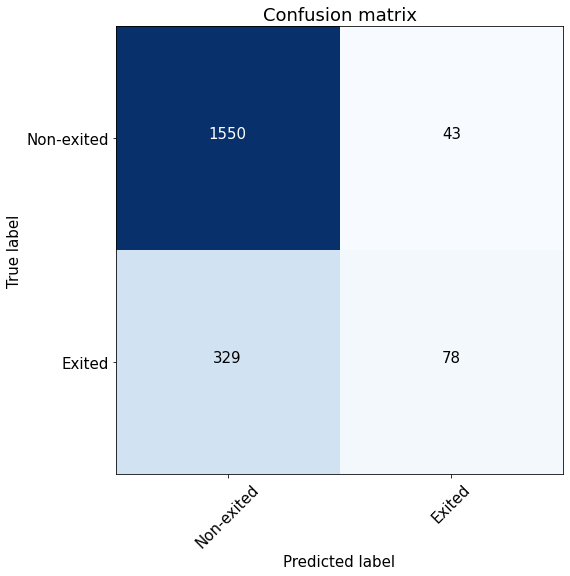

In [16]:
cnf_matrix = confusion_matrix(y_test, lr.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

In [17]:
report = classification_report(y_test, my_lr.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.82      0.97      0.89      1593
      Exited       0.65      0.18      0.29       407

    accuracy                           0.81      2000
   macro avg       0.74      0.58      0.59      2000
weighted avg       0.79      0.81      0.77      2000



In [18]:
report = classification_report(y_test, lr.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.82      0.97      0.89      1593
      Exited       0.64      0.19      0.30       407

    accuracy                           0.81      2000
   macro avg       0.73      0.58      0.59      2000
weighted avg       0.79      0.81      0.77      2000



Матрицы ошибок различаются не очень сильно. Концентрация значений в левом верхнем сегменте матрицы может быть связана с несбалансированностью датасета. Метрики также практически совпадают. Стоит отметить то, что обучение моей модели происходит намного дольше, чем реализованной в sklearn.

# KNN

Моя реализация KNN

In [19]:
from collections import Counter

class KNeighborsClassifier_:
    def __init__(self, k=5):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
    def __predict_class(self, data_test):
        distances = []
        targets = []
        for i in range(len(self.X_train)):
            distances.append([np.linalg.norm(data_test - self.X_train[i]), i])
        distances = sorted(distances)
            
        for i in range(self.k):
            index = distances[i][1]
            targets.append(self.y_train[index])
        return Counter(targets).most_common(1)[0][0]
    
    def predict(self, X):
        X_ = np.array(X)
        
        return np.array([self.__predict_class(X_[i]) == 1.0 for i in range(len(X_))])

Обучение моделей

In [20]:
my_knn = KNeighborsClassifier_()
my_knn.fit(x_train, y_train)

In [21]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

Сравнение результатов

Confusion matrix
[[1503   90]
 [ 225  182]]


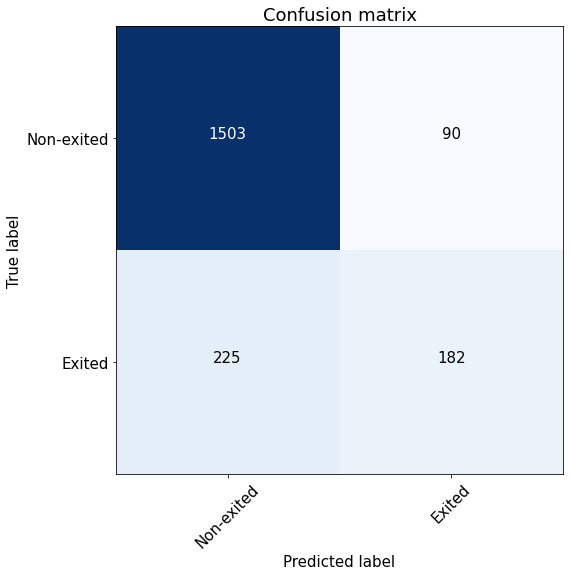

In [22]:
cnf_matrix = confusion_matrix(y_test, my_knn.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

Confusion matrix
[[1503   90]
 [ 225  182]]


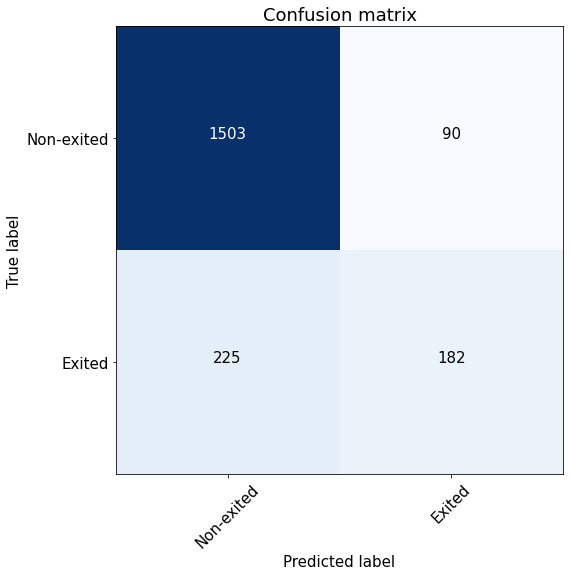

In [23]:
cnf_matrix = confusion_matrix(y_test, knn.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

In [24]:
report = classification_report(y_test, my_knn.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.87      0.94      0.91      1593
      Exited       0.67      0.45      0.54       407

    accuracy                           0.84      2000
   macro avg       0.77      0.70      0.72      2000
weighted avg       0.83      0.84      0.83      2000



In [25]:
report = classification_report(y_test, knn.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.87      0.94      0.91      1593
      Exited       0.67      0.45      0.54       407

    accuracy                           0.84      2000
   macro avg       0.77      0.70      0.72      2000
weighted avg       0.83      0.84      0.83      2000



Матрицы ошибок и метрики полностью совпадают. Однако, моя реализация работает намного медленнее, чем реализация из sklearn.

# Дерево решений

Моя реализация дерева решений

In [26]:
class Node:
    def __init__(self, x, y, idxs, min_leaf_size=5):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf_size = min_leaf_size
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.lhs_idxs = None
        self.rhs_idxs = None
        
        self.__find_var_split()
        
    def __find_var_split(self):
        for c in range(self.x.shape[1]): 
            self.__find_split(c)
        if self.__is_leaf(): 
            return
        self.lhs = Node(self.x, self.y, self.idxs[self.lhs_idxs], self.min_leaf_size)
        self.rhs = Node(self.x, self.y, self.idxs[self.rhs_idxs], self.min_leaf_size)
        
    def __find_split(self, var_idx):
      
        x = self.x.values[self.idxs, var_idx]

        for r in range(len(self.idxs)):
            lhs = np.nonzero(x <= x[r])[0]
            rhs = np.nonzero(x > x[r])[0]
            if len(lhs) < self.min_leaf_size or len(rhs) < self.min_leaf_size:
                continue

            curr_score = self.__find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.split = x[r]
                self.score = curr_score
                
                self.lhs_idxs = lhs
                self.rhs_idxs = rhs
                
    def __find_score(self, lhs, rhs):
        y = self.y[self.idxs]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                                
    def __is_leaf(self): 
        return self.lhs_idxs is None and self.rhs_idxs is None               

    def predict(self, x):
        return np.array([self.__predict_row(xi) >=0.5 for xi in x])

    def __predict_row(self, xi):
        if self.__is_leaf(): 
            return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.__predict_row(xi)
    
class DecisionTreeClassifier_:
    def fit(self, X, y, min_leaf_size = 5):
        self.dtree = Node(X, np.array(y), np.array(np.arange(len(y))), min_leaf_size)
        return self
  
    def predict(self, X):
        return self.dtree.predict(X.values)

Обучение моделей

In [27]:
my_dt = DecisionTreeClassifier_()
my_dt.fit(x_train, y_train)

In [28]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

Сравнение результатов

Confusion matrix
[[1416  177]
 [ 208  199]]


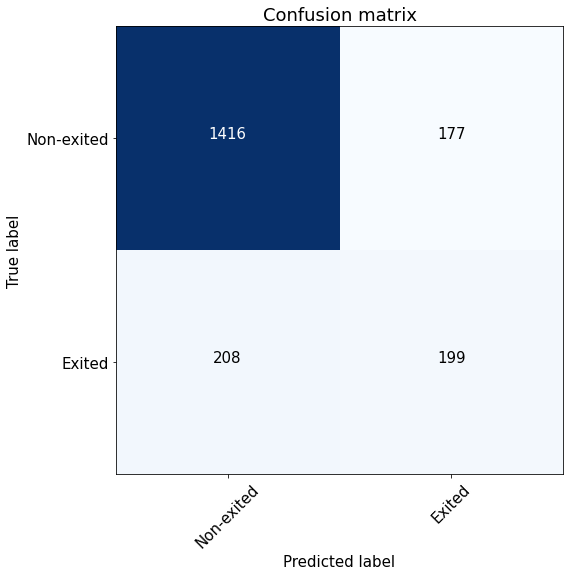

In [29]:
cnf_matrix = confusion_matrix(y_test, my_dt.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

Confusion matrix
[[1384  209]
 [ 191  216]]


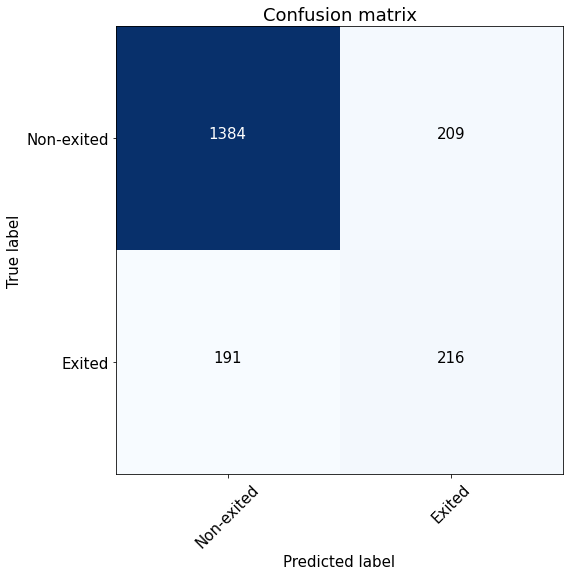

In [30]:
cnf_matrix = confusion_matrix(y_test, dt.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

In [31]:
report = classification_report(y_test, my_dt.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.87      0.89      0.88      1593
      Exited       0.53      0.49      0.51       407

    accuracy                           0.81      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.80      0.81      0.80      2000



In [32]:
report = classification_report(y_test, dt.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.88      0.87      0.87      1593
      Exited       0.51      0.53      0.52       407

    accuracy                           0.80      2000
   macro avg       0.69      0.70      0.70      2000
weighted avg       0.80      0.80      0.80      2000



In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=50)
clf.fit(x_train, y_train)
report = classification_report(y_test, clf.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

Матрицы ошибок немного различаются. Моя модель лучше определила класс non-exited, но хуже определила класс exited. Метрики различаются в основном на 1-2 %.

# SVM

Моя реализация svm

In [33]:
class SVM_():
    def __init__(self, alpha=0.01, etha=0.01, eps=0.01, epochs=300):
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        self._eps = eps
        self._prev_loss = float('inf')
    
    def fit(self, X, y, verbose=False):
        X_ = self.__extend(np.array(X))
        y_ = np.array(y)
        
        for i in range(len(y_)):
            if y_[i] == 0.0:
                y_[i] = -1.0

        self._weights = np.random.normal(size=X_.shape[1])
        
        epochs = 0
        while True:
            loss = 0
            for i, x in enumerate(X_):
                margin = y_[i] * np.dot(self._weights, x)
                if margin >= 1:
                    self._weights = self._weights - self._etha * self._alpha * self._weights / self._epochs
                else:
                    self._weights = self._weights + self._etha * (y_[i] * x - self._alpha * self._weights / self._epochs)
                loss += self.__soft_margin_loss(x, y_[i])
            if epochs == self._epochs or abs(self._prev_loss - loss) <= self._eps:
                return
            
            self._prev_loss = loss
            epochs += 1
            
    def predict(self, X):
        X_ext = self.__extend(np.array(X))
        return np.array([np.sign(np.dot(self._weights, x)) == 1 for x in X_ext]) 
    
    def __extend(self, x):
        x_extended = np.zeros((x.shape[0], x.shape[1] + 1))
        x_extended[:,:-1] = x
        x_extended[:,-1] = int(1)  
        return x_extended
    
    def __hinge_loss(self, x, y):
        return max(0, 1 - y * np.dot(x, self._weights))
    
    def __soft_margin_loss(self, x, y):
        return self.__hinge_loss(x, y) + self._alpha * np.dot(self._weights, self._weights) / 2

Обучение моделей

In [34]:
my_svm = SVM_()
my_svm.fit(x_train, y_train)

In [35]:
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

SVC(kernel='linear')

Сравнение результатов

Confusion matrix
[[1593    0]
 [ 407    0]]


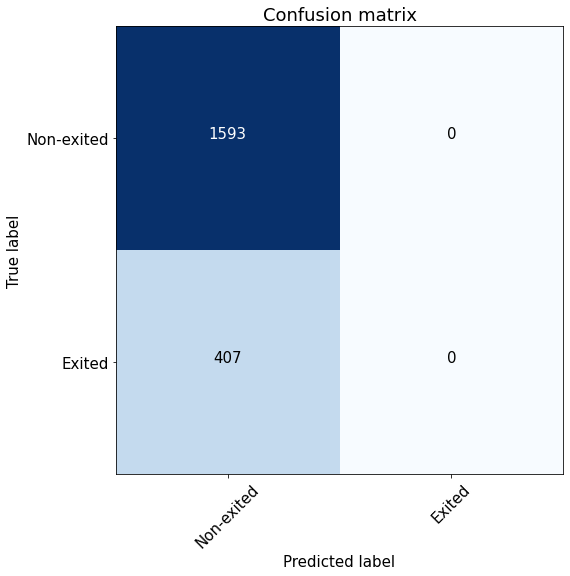

In [36]:
cnf_matrix = confusion_matrix(y_test, my_svm.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

Confusion matrix
[[1593    0]
 [ 407    0]]


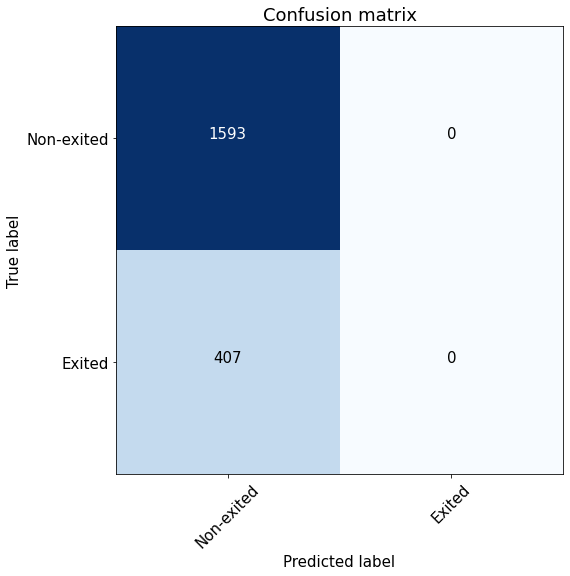

In [37]:
cnf_matrix = confusion_matrix(y_test, svm.predict(x_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

In [38]:
report = classification_report(y_test, my_svm.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.80      1.00      0.89      1593
      Exited       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
report = classification_report(y_test, svm.predict(x_test), target_names=['Non-exited', 'Exited'])
print(report)

              precision    recall  f1-score   support

  Non-exited       0.80      1.00      0.89      1593
      Exited       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Как можно видеть, обе модели плохо подходят для задачи классификации на данном датасете. Матрицы ошибок и метрики полностью совпадают. При использовании другого значения kernel для модели из sklearn можно получить вполне хорошие результаты.

# Выводы

Проблемой данного датасета является его несбаланстрованность, что серьезно повлияло на точность некоторых алгоритмов. Лучше всего себя показало дерево решений. Несмотря на свою простоту, KNN также показал достойные результаты. Хуже всего отработал svm с линейным ядром, но при подборе правильных параметров алгоритм svm из sklearn способен показать хорошие результаты. Алгоритмы, реализованные мной, и алгоритмы из sklearn показали примерно одинаковые результаты, но мои работали заметно медленнее. 